In [8]:

from qiskit import QuantumCircuit, Aer, execute
from qiskit.circuit.library import MCMTVChain
import numpy as np

def grovers_contains_negative(lst):
    n = len(lst)  # Number of items in the list
    num_iterations = int(np.sqrt(n))  # Number of Grover iterations
    qc = QuantumCircuit(n + 1, 1)
    
    # Initialization: Apply Hadamard gates to create a superposition
    qc.h(range(n + 1))
    
    for _ in range(num_iterations):
        # Oracle: mark the negative numbers
        for i, number in enumerate(lst):
            if number < 0:
                qc.x(i)
        qc.mct(list(range(n)), n)  # Multi-controlled-toffoli
        for i, number in enumerate(lst):
            if number < 0:
                qc.x(i)
        
        # Diffusion operator (amplification)
        qc.h(range(n))
        qc.x(range(n))
        qc.h(n - 1)
        qc.mct(list(range(n - 1)), n - 1)  # Multi-controlled-toffoli
        qc.h(n - 1)
        qc.x(range(n))
        qc.h(range(n))

    # Measurement
    qc.measure(0, 0)
    
    # Execute the circuit
    backend = Aer.get_backend('qasm_simulator')
    result = execute(qc, backend, shots=1).result()
    counts = result.get_counts()
    qc.draw()
    # Check the result
    return '1' in counts.keys()

# Example usage:
list_of_numbers = [1, 5, -3, 7, 2, -9]
print("------------------------------------")
print("test case 1, mixed list: [1, 5, -3, 7, 2, -9]")
result = grovers_contains_negative(list_of_numbers)
print("Does the list contain negative numbers?", result)

list_of_numbers = [1, 5, 3, 7, 2, 9]
print("------------------------------------")
print("test case 2, positive list: [1, 5, 3, 7, 2, 9]")
result = grovers_contains_negative(list_of_numbers)
print("Does the list contain negative numbers?", result)

list_of_numbers = [-1, -5, -3, -7, -2, -9]
print("------------------------------------")
print("test case 3, negative list: [-1, -5, -3, -7, -2, -9]")
result = grovers_contains_negative(list_of_numbers)
print("Does the list contain negative numbers?", result)




------------------------------------
test case 1, mixed list: [1, 5, -3, 7, 2, -9]
Does the list contain negative numbers? True
------------------------------------
test case 2, positive list: [1, 5, 3, 7, 2, 9]
Does the list contain negative numbers? False
------------------------------------
test case 3, negative list: [-1, -5, -3, -7, -2, -9]
Does the list contain negative numbers? True


------------------------------------
test case 1, mixed list: [1, 5, -3, 7, 2, -9]
Are there negative numbers in the list? True
Negative numbers in the list: [-3, -9]
------------------------------------
test case 2, all positive list: [1, 5, 3, 7, 2, 9]
Are there negative numbers in the list? False
Negative numbers in the list: []
------------------------------------
test case 3, all negative list: [-1, -5, -3, -7, -2, -9]
Are there negative numbers in the list? True
Negative numbers in the list: [-2, -9, -7, -5, -3, -1]


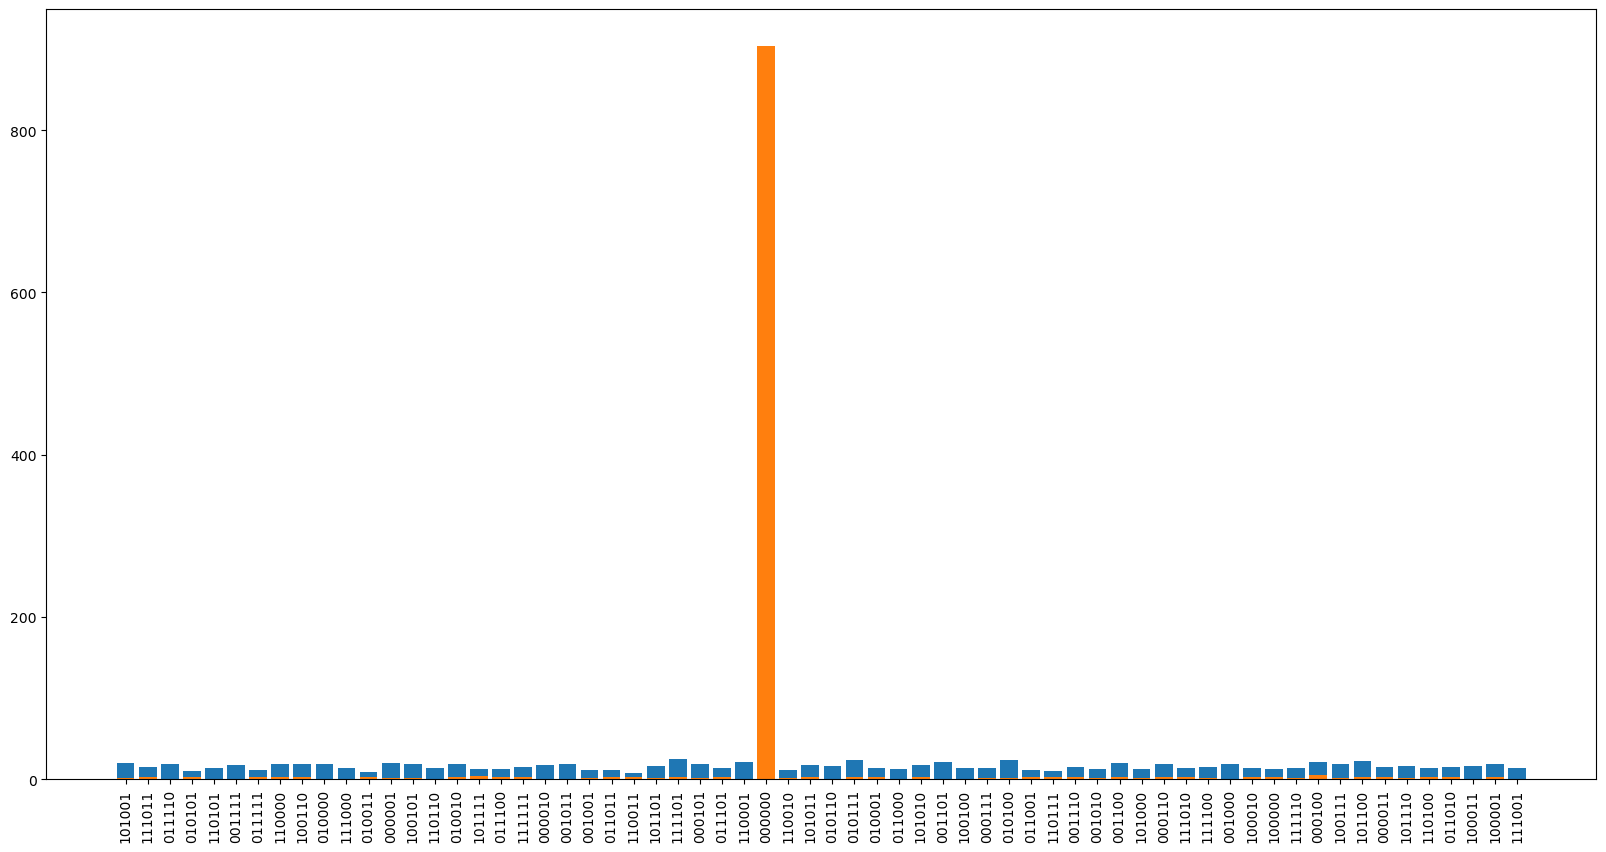

In [10]:
from qiskit import QuantumCircuit, Aer, execute
from datetime import datetime
import os
import numpy as np
import matplotlib.pyplot as plt
import time
class GroversNegativeFinder:
    def __init__(self, lst, num_negatives):
        self.lst = lst
        self.n = len(lst)
        self.num_iterations = int(np.sqrt(self.n))
        self.qc = QuantumCircuit(self.n + 1, self.n)
        self.num_negatives = num_negatives
        self.start_time = datetime.now()


    def initialize(self):
        self.qc.h(range(self.n + 1))

    def oracle(self):
        for i, number in enumerate(self.lst):
            if number < 0:
                self.qc.x(i)
        self.qc.mct(list(range(self.n)), self.n)
        for i, number in enumerate(self.lst):
            if number < 0:
                self.qc.x(i)

    def diffusion(self):
        '''
        Diffusion operator (amplification)
        H^n X H^n ● H^n X H^n
        The diffusion operator flips the amplitude about the average so that the amplitude of the solution is increased and the amplitude of the other states is decreased.
        '''
        self.qc.h(range(self.n))
        self.qc.x(range(self.n))
        self.qc.h(self.n - 1)
        self.qc.mct(list(range(self.n - 1)), self.n - 1)
        self.qc.h(self.n - 1)
        self.qc.x(range(self.n))
        self.qc.h(range(self.n))

    def measure(self):

        self.qc.measure(range(self.n), range(self.n))
        fig = self.qc.draw('mpl')
        return fig

    
    def find_negatives(self):
        '''
        Find the negative numbers in the list using Grover's algorithm
        '''
        unique_negatives = set()
        
        while len(unique_negatives) < self.num_negatives:
            for _ in range(self.num_iterations):
                self.oracle()
                self.diffusion()
            fig = self.measure()

            backend = Aer.get_backend('qasm_simulator')
            result = execute(self.qc, backend, shots=1000).result()
            counts = result.get_counts()

            sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
            most_probable = [k for k, v in sorted_counts[:self.num_negatives]]

            for k in most_probable:
                idx = [i for i, bit in enumerate(reversed(k)) if bit == '1']
                unique_negatives.update([self.lst[i] for i in idx if self.lst[i] < 0])

            # Reset Quantum Circuit for next iteration if not all negative numbers are found otherwise save the circuit
            if len(unique_negatives) < self.num_negatives:
                self.qc.data.clear()
                self.initialize()
            else:
                 self.graph_save_to_folder(fig, counts, most_probable, unique_negatives)
                
        return list(unique_negatives)

    def graph_save_to_folder(self, fig, counts, most_probable, unique_negatives):
        current_time = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        exec_time = datetime.now()-self.start_time
        os.mkdir(current_time)
        fig.savefig(f"{current_time}/circuit.png")
        plt.bar(counts.keys(), counts.values())
        # increase the width of the image
        plt.gcf().set_size_inches(20, 10)
        #make x axis labels vertical
        plt.xticks(rotation=90)
        plt.savefig(f"{current_time}/histogram.png")
        #write a txt report file
        with open(f"{current_time}/report.txt", "w") as f:
            f.write(f"List of numbers: {self.lst}\n")
            f.write(f"Number of negative numbers: {self.num_negatives}\n")
            f.write(f"Number of iterations: {self.num_iterations}\n")
            f.write(f"Execution time: {exec_time}\n")
            f.write(f"Counts: {counts}\n")
            f.write(f"Most probable: {most_probable}\n")
            f.write(f"Unique negative numbers: {unique_negatives}\n")
            f.write(f"Number of unique negative numbers: {len(unique_negatives)}\n")

        self.exec_time= exec_time

    

# Test cases for all positive numbers, all negative numbers, and a mix of both
list_of_numbers = [1, 5, -3, 7, 2, -9]
result = GroversNegativeFinder(list_of_numbers,len([i for i in list_of_numbers if i < 0])).find_negatives()
print("------------------------------------")
print("test case 1, mixed list: [1, 5, -3, 7, 2, -9]")
print("Are there negative numbers in the list? "+str(True if len(result) > 0 else False))
print("Negative numbers in the list:", result)


list_of_numbers = [1, 5, 3, 7, 2, 9]
result = GroversNegativeFinder(list_of_numbers,len([i for i in list_of_numbers if i < 0])).find_negatives()
print("------------------------------------")
print("test case 2, all positive list: [1, 5, 3, 7, 2, 9]")
print("Are there negative numbers in the list? "+str(True if len(result) > 0 else False))
print("Negative numbers in the list:", result)

list_of_numbers = [-1, -5, -3, -7, -2, -9]
result = GroversNegativeFinder(list_of_numbers,len([i for i in list_of_numbers if i < 0])).find_negatives()
print("------------------------------------")
print("test case 3, all negative list: [-1, -5, -3, -7, -2, -9]")
print("Are there negative numbers in the list? "+str(True if len(result) > 0 else False))
print("Negative numbers in the list:", result)
